### Ejercicio 3: Validación y rediseño.

Una vez realizados los cálculos analíticos del **Ejercicio 1** (Planta de 1er orden + PI), procederemos a validar los resultados mediante simulación.

Asumiremos que los cálculos teóricos para $\zeta=0.707$ y $\omega_n=5$ rad/s arrojaron los siguientes valores:
* $K_p = 0.507$
* $K_i = 2.5$

**Instrucciones:**

1.  **Ejecute la celda de código inferior:** Esta celda contiene la definición del sistema con los valores teóricos calculados, genera la gráfica de respuesta al escalón y muestra las métricas de desempeño.
2.  **Analice los resultados:** Observe las métricas impresas. ¿Se cumple el sobreimpulso máximo del 5% que prometía la teoría?

--- Función de transferencia de lazo cerrado (Teórico). ---
<TransferFunction>: sys[4]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

     5.07 s + 25
  -----------------
  s^2 + 7.07 s + 25


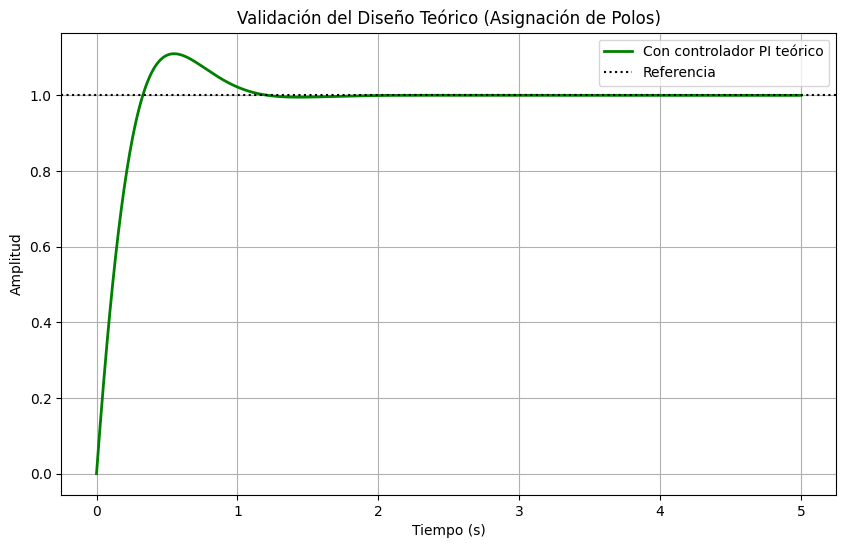

--- Análisis de Polos y Ceros. ---
Polos del sistema controlado: [-3.535+3.53606773j -3.535-3.53606773j]
Ceros del sistema controlado: [-4.93096647+0.j]


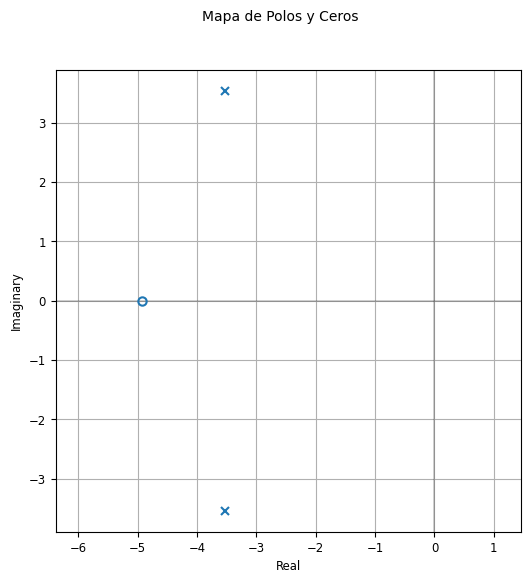


--- Métricas de desempeño del sistema (PI Teórico). ---
- Métricas teóricas esperadas para zeta=0.707 y wn=5 rad/s:
           - Mp ≈ 4.3%
           - Ts ≈ 1.13 s.

- Métricas reales de la simulación:
Sobreimpulso (Overshoot):       11.01 %
Tiempo de Establecimiento (2%): 1.0264 s
Valor Final:                    1.0000


In [1]:
import control as ct
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Definición del sistema y controlador. ---
# Planta Gp(s) = 10 / (s+2).
num_p = [10]
den_p = [1, 2]
Gp = ct.tf(num_p, den_p)

# Controlador PI Teórico: Gc = (Kps + Ki)/s.
# Valores obtenidos del diseño teórico (Zeta=0.707)
Kp_teo = 0.507
Ki_teo = 2.5
Gc = ct.tf([Kp_teo, Ki_teo], [1, 0])

# Sistema en lazo cerrado con el controlador: G_LC = (Gc*Gp) / (1 + Gc*Gp).
G_LC = ct.feedback(Gc * Gp, 1)
print("--- Función de transferencia de lazo cerrado (Teórico). ---")
print(G_LC)


# --- 2. Simulación y gráfica de las respuestas. ---
# Vector de tiempo: 0 a 5 segundos.
t = np.linspace(0, 5, 1000)

# Obtener respuesta al escalón.
_, y_LC = ct.step_response(G_LC, T=t)

plt.figure(figsize=(10, 6))
plt.plot(t, y_LC, 'g-', linewidth=2,  label='Con controlador PI teórico')
plt.axhline(y=1, color='k', linestyle=':', label='Referencia')

plt.title('Validación del Diseño Teórico (Asignación de Polos)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.show()


# --- 3. Mapa de Polos y Ceros ---
print("--- Análisis de Polos y Ceros. ---")
polos = ct.poles(G_LC)
ceros = ct.zeros(G_LC)
print(f"Polos del sistema controlado: {polos}")
print(f"Ceros del sistema controlado: {ceros}")

plt.figure(figsize=(6, 6))
ct.pzmap(G_LC, title='Mapa de Polos y Ceros')
plt.grid(True)
plt.show()


# --- 4. Métricas de desempeño. ---
info = ct.step_info(G_LC)
print("\n--- Métricas de desempeño del sistema (PI Teórico). ---")
print("""- Métricas teóricas esperadas para zeta=0.707 y wn=5 rad/s:
           - Mp ≈ 4.3%
           - Ts ≈ 1.13 s.""")

print(f"\n- Métricas reales de la simulación:")
print(f"Sobreimpulso (Overshoot):       {info['Overshoot']:.2f} %")
print(f"Tiempo de Establecimiento (2%): {info['SettlingTime']:.4f} s")
print(f"Valor Final:                    {y_LC[-1]:.4f}")

#### Realice lo siguiente.

Al ejecutar la simulación anterior, notará que el sobreimpulso real es mayor al 4.3% esperado teóricamente.
Esto se debe a la presencia del cero ($s = -K_i/K_p$) introducido por el controlador PI, el cual no fue considerado en las fórmulas estándar de segundo orden usadas para el cálculo.

**Actividad a realizar:**
Rediseñe las ganancias del controlador ($K_p$ y/o $K_i$) para lograr que el sobreimpulso sea **menor o igual al 5%**.

1.  **Rediseño:** Puede proponer un nuevo $\zeta$ (mayor a 0.707) y recalcular, o utilizar el método de LGR para ajustar la ganancia. *Nota: Para este rediseño, puede ser flexible con el requisito del tiempo de establecimiento.* 
2.  **Justificación:** En una nueva celda de Markdown (incluyendo sus cálculos en fotografía, como cólidgo o como celda de Markdown/Python), justifique brevemente su elección mostrando el nuevo cálculo. **(2.5 puntos)**
3.  **Comparación:** Agregue una celda de código final donde grafique en la misma figura: **(1.0 puntos)**
    * La respuesta con el PI Teórico (Original).
    * La respuesta con el PI Rediseñado (Modificado).
    * Imprima las nuevas métricas para verificar el cumplimiento.

## 4. Desarrollo Práctico: Diseño del Controlador

> **Objetivo:** Obtener un sobreimpulso ($M_p$) menor al **4.3%**.

### I. Parámetros del Sistema
| Componente | Función / Variable | Valor |
| :--- | :---: | :---: |
| **Planta** | $G(s)$ | $\frac{10}{s + 2}$ |
| **Controlador (Proporcional)** | $K_p$ | $1.5$ |
| **Controlador (Integral)** | $K_i$ | $2.8$ |

### II. Análisis de Lazo Cerrado
La función de transferencia del controlador PI se define como:
$$C(s) = K_p + \frac{K_i}{s} = \frac{K_p s + K_i}{s}$$

La ecuación característica del sistema en lazo cerrado está dada por $1 + C(s)G(s) = 0$. Sustituyendo los valores:

$$s(s + 2) + 10(K_p s + K_i) = 0$$

Desarrollando y agrupando términos semejantes:
$$s^2 + (2 + 10K_p)s + 10K_i = 0$$

Sustituyendo $K_p = 1.5$ y $K_i = 2.8$:
$$s^2 + (2 + 15)s + 28 = 0$$

**Ecuación Característica Final:**
$$s^2 + 17s + 28 = 0$$

### III. Obtención de Parámetros ($\zeta$ y $\omega_n$)
Comparando con la forma estándar de segundo orden ($s^2 + 2\zeta\omega_n s + \omega_n^2 = 0$):

1.  **Frecuencia natural ($\omega_n$):**
    $$\omega_n^2 = 28 \implies \omega_n = \sqrt{28} \approx 5.2915$$

2.  **Coeficiente de amortiguamiento ($\zeta$):**
    $$2\zeta\omega_n = 17 \implies \zeta = \frac{17}{2(5.2915)}$$

---
### **Resultados Finales**

> **$\omega_n = 5.2915$ rad/s**
>
> **$\zeta = 1.606$** (Sistema Sobreamortiguado)


=== Lazo cerrado (Controlador Teórico) ===
<TransferFunction>: sys[28]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

     5.07 s + 25
  -----------------
  s^2 + 7.07 s + 25

=== Lazo cerrado (Controlador Rediseñado) ===
<TransferFunction>: sys[31]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

     4 s + 10
  --------------
  s^2 + 6 s + 10


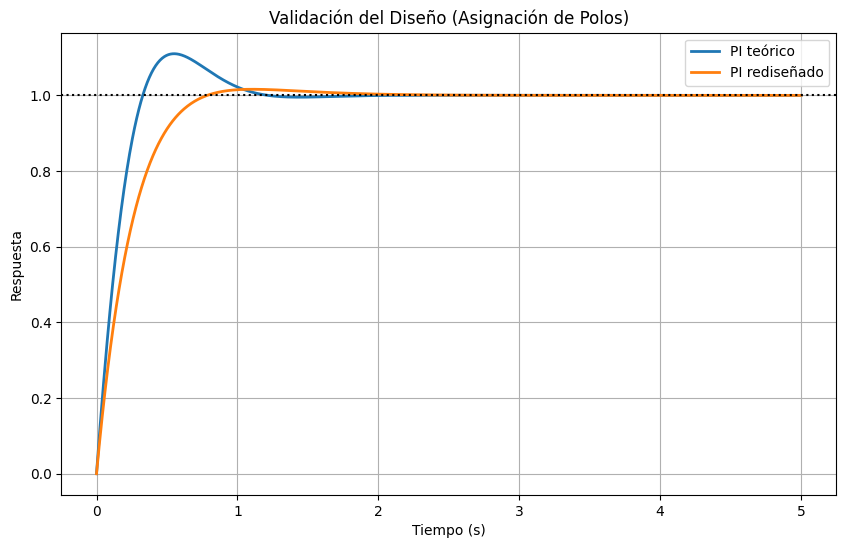


=== Polos y ceros (PI Teórico) ===
Polos: [-3.535+3.53606773j -3.535-3.53606773j]
Ceros: [-4.93096647+0.j]


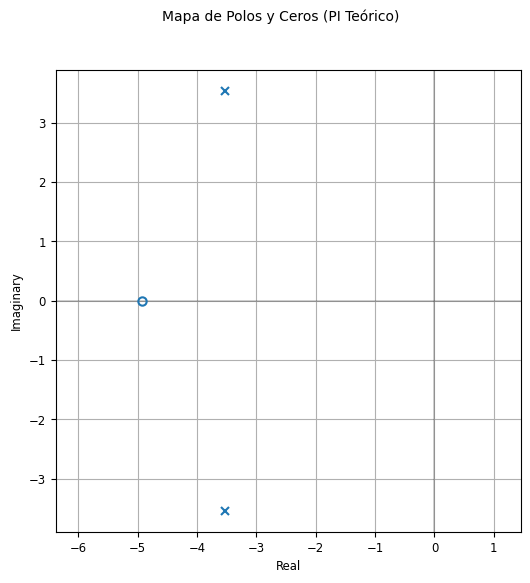


=== Polos y ceros (PI Rediseñado) ===
Polos: [-3.+1.j -3.-1.j]
Ceros: [-2.5+0.j]


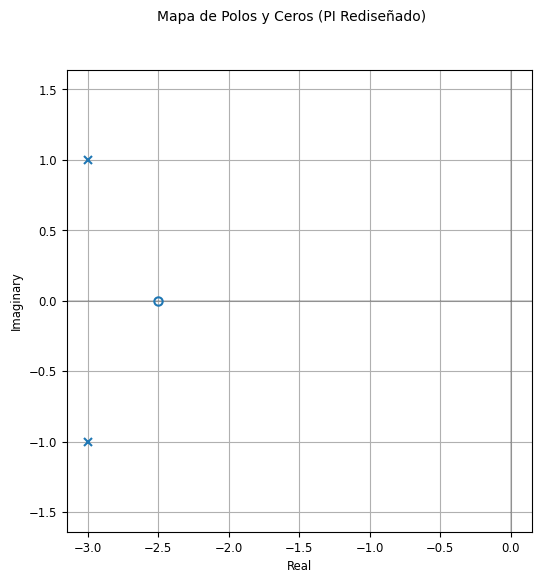


=== Desempeño: PI Teórico ===
Esperado (zeta=0.707, wn=5): Mp ≈ 4.3%, Ts ≈ 1.13 s
Overshoot:        11.01 %
Ts (2%):          1.0264 s
Valor final:      1.0000

=== Desempeño: PI Rediseñado ===
Esperado (zeta=0.8, wn≈4.24): Mp pequeño, Ts similar
Overshoot:        1.61 %
Ts (2%):          0.6978 s
Valor final:      1.0000


In [3]:
import control as ct
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------------------------------------------
# 1. DEFINICIÓN DEL SISTEMA Y CONTROLADORES
# -------------------------------------------------------------------

# Planta: Gp(s) = 10 / (s + 2)
planta = ct.tf([10], [1, 2])

# Controlador PI teórico (zeta = 0.707)
kp1, ki1 = 0.507, 2.5
PI_teo = ct.tf([kp1, ki1], [1, 0])

# Controlador PI rediseñado (zeta = 0.8)
kp2, ki2 = 0.4, 1
PI_red = ct.tf([kp2, ki2], [1, 0])

# Lazos cerrados
LC_teo = ct.feedback(PI_teo * planta)
LC_red = ct.feedback(PI_red * planta)

print("\n=== Lazo cerrado (Controlador Teórico) ===")
print(LC_teo)
print("\n=== Lazo cerrado (Controlador Rediseñado) ===")
print(LC_red)

# -------------------------------------------------------------------
# 2. RESPUESTA AL ESCALÓN
# -------------------------------------------------------------------

tiempo = np.linspace(0, 5, 1000)

_, resp_teo = ct.step_response(LC_teo, T=tiempo)
_, resp_red = ct.step_response(LC_red, T=tiempo)

plt.figure(figsize=(10, 6))
plt.plot(tiempo, resp_teo, label="PI teórico", linewidth=2)
plt.plot(tiempo, resp_red, label="PI rediseñado", linewidth=2)
plt.axhline(1, linestyle=':', color='k')

plt.title("Validación del Diseño (Asignación de Polos)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Respuesta")
plt.grid(True)
plt.legend()
plt.show()

# -------------------------------------------------------------------
# 3. MAPA DE POLOS Y CEROS
# -------------------------------------------------------------------

print("\n=== Polos y ceros (PI Teórico) ===")
print("Polos:", ct.poles(LC_teo))
print("Ceros:", ct.zeros(LC_teo))

plt.figure(figsize=(6, 6))
ct.pzmap(LC_teo, title="Mapa de Polos y Ceros (PI Teórico)")
plt.grid(True)
plt.show()

print("\n=== Polos y ceros (PI Rediseñado) ===")
print("Polos:", ct.poles(LC_red))
print("Ceros:", ct.zeros(LC_red))

plt.figure(figsize=(6, 6))
ct.pzmap(LC_red, title="Mapa de Polos y Ceros (PI Rediseñado)")
plt.grid(True)
plt.show()

# -------------------------------------------------------------------
# 4. MÉTRICAS DE DESEMPEÑO
# -------------------------------------------------------------------

info_teo = ct.step_info(LC_teo)
info_red = ct.step_info(LC_red)

print("\n=== Desempeño: PI Teórico ===")
print("Esperado (zeta=0.707, wn=5): Mp ≈ 4.3%, Ts ≈ 1.13 s")
print(f"Overshoot:        {info_teo['Overshoot']:.2f} %")
print(f"Ts (2%):          {info_teo['SettlingTime']:.4f} s")
print(f"Valor final:      {resp_teo[-1]:.4f}")

print("\n=== Desempeño: PI Rediseñado ===")
print("Esperado (zeta=0.8, wn≈4.24): Mp pequeño, Ts similar")
print(f"Overshoot:        {info_red['Overshoot']:.2f} %")
print(f"Ts (2%):          {info_red['SettlingTime']:.4f} s")
print(f"Valor final:      {resp_red[-1]:.4f}")
